# Modelo Multimodal

Com base em todos os experimentos realizados anteriormente, observamos que os melhores resultados para o problema de três classes foram obtidos utilizando as matrizes de correlação e as séries temporais cruas em uma única etapa de treinamento (notebooks 1.1_3classes e 2.1_3classes).

Por isso, decidimos realizar um empilhamento (stacking) desses dois modelos, combinando suas previsões por meio de um modelo de aprendizado de máquina simples. A regressão logística foi escolhida por sua simplicidade e por ter apresentado bom desempenho.

Adiantando os resultados, o modelo multimodal não trouxe ganhos significativos em relação ao modelo baseado apenas nas matrizes de correlação (1.1_3classes). Após diversas execuções, percebemos que, na maioria das vezes, o modelo empilhado teve desempenho inferior ou, quando semelhante, basicamente replicava a saída do modelo com matrizes de correlação. Em raras exceções, a combinação multimodal apresentou uma leve vantagem, variando entre 1% e 3%, o que consideramos irrelevante. Isso indica que a forma como as regiões do cérebro se conectam, capturada pela matriz de correlação, é o fator mais relevante para distinguir entre as classes do problema.

In [1]:
%load_ext autoreload

In [2]:
import sys
import os
import time
import torch
import pickle
import parkinson

import numpy as np
import pandas as pd
import networkx as nx

import torch
import torch.nn.functional as F

from torch import nn
from joblib import Parallel, delayed
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.utils.class_weight import compute_sample_weight

from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBClassifier

In [3]:
print(os.listdir('../'))
sys.path.append('../')

['README.md', 'pyproject.toml', 'outputs', 'parkinson', 'Makefile', 'poetry.toml', 'data', 'requirements.txt', 'weights', '.git', 'notebooks', '.venv', '.gitignore', 'poetry.lock']


In [4]:
RDN = 50
N_CLASSES = 3
BATCH_SIZE = 32
N_EPOCHS = 200
PATIENCE = 20
LR = 0.0001
DECAY = 0.000001
SAVE_PATH = '../outputs/5.0_final'

## Modelo Correlation Matrix

### Processamento dos dados

In [5]:
# lendo os arquivos de dados
print('Started file reading...')
parkinson_data = parkinson.utils.data.batch_read('../data/PDs_columns')
control_data = parkinson.utils.data.batch_read('../data/Controls_columns')
prodomal_data = parkinson.utils.data.batch_read('../data/Prodomals_columns')
print('File reading completed.')

# selecionando as colunas de atlas AAL3, o atlas de conectividade cerebral
control_atlas_data = parkinson.utils.data.select_atlas_columns(control_data, 'AAL3')
parkinson_atlas_data = parkinson.utils.data.select_atlas_columns(parkinson_data, 'AAL3')
prodomal_atlas_data = parkinson.utils.data.select_atlas_columns(prodomal_data, 'AAL3')

# Geração da matriz de correlação.
parkinson_correlation_matrix = parkinson.utils.correlation.sliding_window_correlation(parkinson_atlas_data)
control_correlation_matrix = parkinson.utils.correlation.sliding_window_correlation(control_atlas_data)
prodomal_correlation_matrix = parkinson.utils.correlation.sliding_window_correlation(prodomal_atlas_data)

# Concatenando grupo controle e grupo de Parkinson
# e filtrando os dados para remover entradas com NaN ou infinitos
X = parkinson.utils.data.concatenate_data(parkinson_correlation_matrix, control_correlation_matrix, prodomal_correlation_matrix)
y = parkinson.utils.data.concatenate_data([1 for _ in range(len(parkinson_data))], [0 for _ in range(len(control_data))], [2 for _ in range(len(prodomal_data))])
X, y = parkinson.utils.data.filter_data(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RDN, stratify=y, shuffle=True)

# Criando DataLoaders
train_loader_cm = parkinson.utils.data.get_torch_dataloader(X_train, y_train, batch_size=BATCH_SIZE, shuffle=False)
test_loader_cm = parkinson.utils.data.get_torch_dataloader(X_test, y_test, batch_size=BATCH_SIZE, shuffle=False)

Started file reading...


100%|██████████| 188/188 [00:04<00:00, 43.83it/s]


File reading completed.


### Treinamento

In [6]:
%%time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = parkinson.NetworkModels.customMLP(input_dim=X_train.shape[1], hidden_dim=16, output_dim=N_CLASSES)
class_weights = parkinson.utils.data.get_torch_class_weights(y_train)

model1.train()
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

out = parkinson.utils.train.train(
    model=model1, 
    train_loader=train_loader_cm, 
    val_loader=None, 
    class_weights=class_weights, 
    device=device, 
    num_epochs=N_EPOCHS, 
    patience=PATIENCE,
    lr=LR,
    path="../weights/5.0_final/corr_matrix"
)

metrics = parkinson.utils.train.evaluate(model1, test_loader_cm, device, path="../weights/5.0_final/corr_matrix")

train-loss: 0.2666  train-acc: 0.9846: 100%|██████████| 200/200 [00:24<00:00,  8.07it/s]


CPU times: user 4.6 s, sys: 13.6 s, total: 18.2 s
Wall time: 25.7 s


 Acurácia       F1  Precisão   Recall
 0.682927 0.667064  0.662767 0.682927


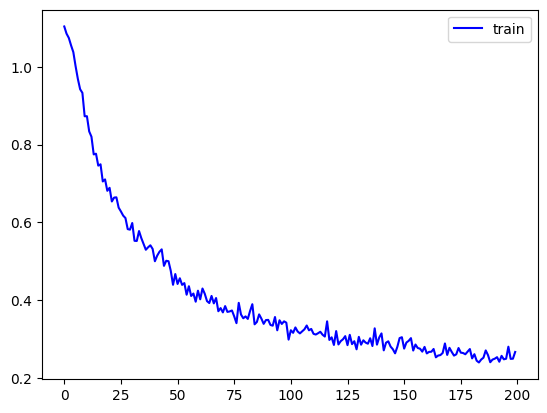

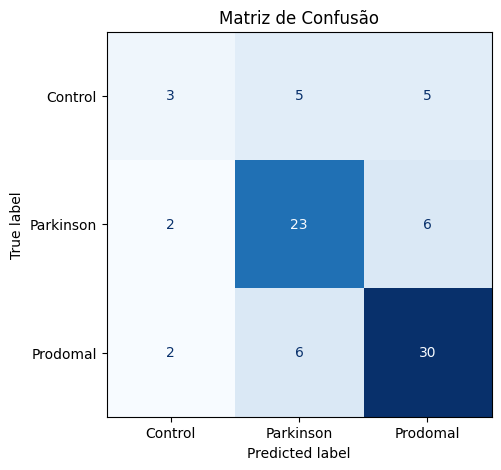

In [7]:
# Criando e plotando os resultados.
parkinson.utils.results.metrics_to_dataframe(metrics)
fig_loss = parkinson.utils.results.plot_losses(out['train_loss'], None)
fig_loss.show()
fig_cf = parkinson.utils.results.plot_confusion_matrix(metrics['preds'], metrics['labels'], class_names=['Control','Parkinson', 'Prodomal'])
fig_cf.show()

# Salvando as figuras.
fig_loss.savefig(f"{SAVE_PATH}/corr_matrix/loss_curve.png", bbox_inches='tight')
fig_cf.savefig(f"{SAVE_PATH}/corr_matrix/confusion_matrix.png", bbox_inches='tight')

## Modelo Time Series

### Processamento dos dados

In [8]:
# Lendo os dados dos arquivos.
print('Started file reading...')
parkinson_data = parkinson.utils.data.batch_read('../data/PDs_columns')
control_data = parkinson.utils.data.batch_read('../data/Controls_columns')
prodomal_data = parkinson.utils.data.batch_read('../data/Prodomals_columns')
print('File reading completed.')

# Selecionando o atlas (estratégia de divisão cerebral: Shen_268 ou atlas ou AAL3).
control_atlas_data = parkinson.utils.data.select_atlas_columns(control_data, 'AAL3')
parkinson_atlas_data = parkinson.utils.data.select_atlas_columns(parkinson_data, 'AAL3')
prodomal_atlas_data = parkinson.utils.data.select_atlas_columns(prodomal_data, 'AAL3')

# Transformando os dados selecionados em séries temporais (shape = [n_pacientes, n_canais, n_observações]).
control_ts_data = parkinson.utils.data.df_to_timeseries(control_atlas_data)
parkinson_ts_data = parkinson.utils.data.df_to_timeseries(parkinson_atlas_data)
prodomal_ts_data = parkinson.utils.data.df_to_timeseries(prodomal_atlas_data)

# Misturando pacientes Controle/Parkinson e trocando valores NaN por zero.
X = parkinson.utils.data.concatenate_data(parkinson_ts_data, control_ts_data, prodomal_ts_data)
y = parkinson.utils.data.concatenate_data([1 for _ in range(len(parkinson_data))], [0 for _ in range(len(control_data))], [2 for _ in range(len(prodomal_data))])
X, y = parkinson.utils.data.filter_data(X, y)

X_train, X_test, y_traina, y_test = train_test_split(X, y, test_size=0.2, random_state=RDN, stratify=y, shuffle=True)

# Criando DataLoader
train_loader_ts = parkinson.utils.data.get_torch_dataloader(X_train, y_traina, batch_size=BATCH_SIZE, shuffle=False)
test_loader_ts = parkinson.utils.data.get_torch_dataloader(X_test, y_test, batch_size=BATCH_SIZE, shuffle=False)

Started file reading...


100%|██████████| 188/188 [00:03<00:00, 48.03it/s]


File reading completed.


### Treinamento

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = parkinson.NetworkModels.customFCN(X_train.shape[1], N_CLASSES)

model2.train()
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

out = parkinson.utils.train.train(model2, train_loader_ts, None, device, N_EPOCHS, PATIENCE, LR, "../weights/5.0_final/time_series", DECAY)

metrics = parkinson.utils.train.evaluate(model2, test_loader_ts, device, "../weights/5.0_final/time_series")

Epoch:   0%|          | 0/200 [00:00<?, ?it/s]/home/labic/merlin_codes/dl/Parkinson-Diagnosis-Deeplearning/.venv/lib/python3.12/site-packages/torch/nn/modules/conv.py:370: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv1d(
train-loss: 0.0015  train-acc: 1.0000: 100%|██████████| 200/200 [00:53<00:00,  3.74it/s]


 Acurácia       F1  Precisão  Recall
  0.52439 0.462661   0.45103 0.52439


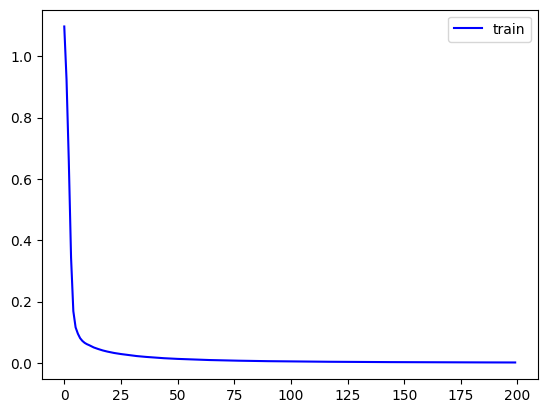

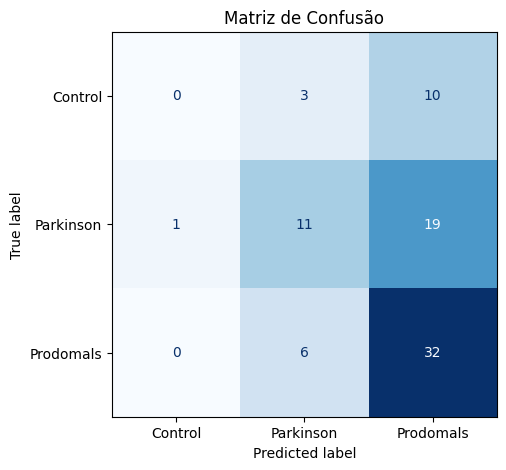

In [10]:
# Criando e plotando os resultados.
parkinson.utils.results.metrics_to_dataframe(metrics)
fig_loss = parkinson.utils.results.plot_losses(out['train_loss'], None)
fig_loss.show()
fig_cf = parkinson.utils.results.plot_confusion_matrix(metrics['preds'], metrics['labels'], class_names=['Control','Parkinson', 'Prodomals'])
fig_cf.show()

# Salvando as figuras.
fig_loss.savefig(f"{SAVE_PATH}/time_series/loss_curve.png", bbox_inches='tight')
fig_cf.savefig(f"{SAVE_PATH}/time_series/confusion_matrix.png", bbox_inches='tight')

## Multimodal

In [11]:
def get_model_logits(model, dataloader, device):
    model.eval()
    model.to(device)

    all_logits = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            if isinstance(batch, (tuple, list)):
                x, y = batch
            elif isinstance(batch, dict):
                x = batch['input']
                y = batch['label']
            else:
                raise ValueError("Unsupported batch format")

            x = x.to(device)
            out = model(x)  # raw logits

            all_logits.append(out.cpu())
            all_labels.append(y)

    logits = torch.cat(all_logits, dim=0).numpy()
    y_all = torch.cat(all_labels, dim=0).numpy()

    return logits, y_all

 Acurácia       F1  Precisão   Recall
 0.682927 0.657274  0.727573 0.682927
Train acc: 1.0


/home/labic/merlin_codes/dl/Parkinson-Diagnosis-Deeplearning/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


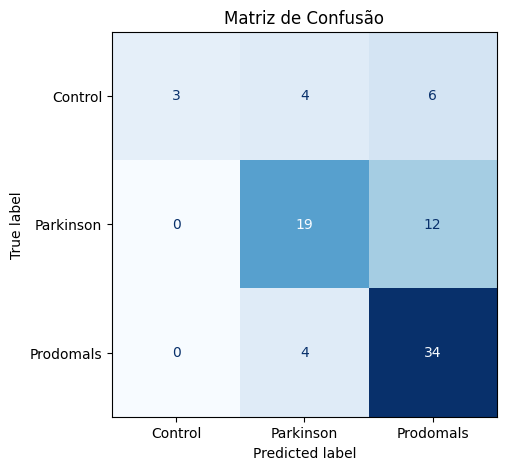

In [12]:
from scipy.special import softmax
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Carregue os pesos dos modelos ANTES de extrair os logits
model1.load_state_dict(torch.load("../weights/5.0_final/corr_matrix/best_model.pth", map_location=device))
model1.to(device)
model1.eval()

model2.load_state_dict(torch.load("../weights/5.0_final/time_series/best_model.pth", map_location=device))
model2.to(device)
model2.eval()

# Extraia os logits e os rótulos (y) usando a nova função
logits1_train, y_train = get_model_logits(model1, train_loader_cm, device)
logits2_train, a       = get_model_logits(model2, train_loader_ts, device)

logits1_test, y_test = get_model_logits(model1, test_loader_cm, device)
logits2_test, _      = get_model_logits(model2, test_loader_ts, device)

# Concatena as probabilidades das duas fontes
X_train = np.concatenate([logits1_train, logits2_train], axis=1)
X_test = np.concatenate([logits1_test, logits2_test], axis=1)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=500,
    class_weight='balanced',
    random_state=RDN
)

model.fit(X_train_scaled, y_train)
preds = model.predict(X_test_scaled)

metrics = {
    'acc': accuracy_score(y_test, preds),
    'f1': f1_score(y_test, preds, average='weighted'),
    'precision': precision_score(y_test, preds, average='weighted'),
    'recall': recall_score(y_test, preds, average='weighted'),
    'preds': preds,
    'labels': y_test
}

parkinson.utils.results.metrics_to_dataframe(metrics)
fig_cf = parkinson.utils.results.plot_confusion_matrix(preds, y_test, class_names=['Control','Parkinson', 'Prodomals'])
fig_cf.show()

# Salvando as figuras.
fig_cf.savefig(f"{SAVE_PATH}/confusion_matrix_final.png", bbox_inches='tight')

# Avaliação no conjunto de treino
preds_train = model.predict(X_train_scaled)
print("Train acc:", accuracy_score(y_train, preds_train))